# Gate Configuration - A Real Use Case

An example for a real use case of the qctoolkit is the search for and evaluation of parameters for pulses that represent quantum gate operations.

## Description of the Experiment
The experiment will typically involve a set of gate pulses $G_j, 0 \leq j \lt N_{Gates}$.

The template for a gate pulse $G_j$ is a sequence of $\epsilon_i, 0 \leq i \lt N_{G_j}$ voltage levels held for time $\Delta t = 1$ ns as illustrated in the figure below (with $N_{G_j} = 7$).

![Template of a gate pulse](img/gate_pulse_scheme.png)

The experiment defines a number of sequences $S_k, 0 \leq k \lt N_{Sequences}$ of the $G_j$ as $$S_k = (G_{m_k(1)}, G_{m_k(2)}, \dots,  G_{m_k(N_{S_k})})$$ where $N_{S_k}$ is the length of sequence $k$ and $m_k(i): \{0, \dots, N_{S_k} - 1\} \rightarrow \{0, \dots, N_{Gates} - 1\}$ is a function that maps an index $i$ to the $m_k(i)$-th gate of sequence $S_k$ and thus fully describes the sequence. (These sequences express the sequential application of the gates to the qubit. In terms of quantum mathematics they may rather be expressed as multiplication of the matrices describing the unitary transformations applied by the gates: $S_k = \prod_{i=N_{S_k} - 1}^{0} G_{m_k(i)} = G_{(N_{S_k} - 1)} \cdot \dots \cdot G_{1} \cdot G_{0}$.)

Measuring and analysing the effects of these sequences on the qubit's state to derive parameters $\epsilon_i$ for gate pulses that achieve certain state transformations is the goal of the experiment.

To this end, every sequence must be extended by some preceeding initialization pulse and a succeeding measurement pulse. Furthermore, due to hardware constraints in measuring, all sequences must be of equal length (which is typically 4 µs). Thus, some sequences require some wait time before initialization to increase their playback duration. These requirements give raise to extended sequences $S_k'$ of the form:
$$S_k' = I_{p(k)} | W_k | S_k | M_{q(k)}$$
where the functions $p(k)$ and $q(k)$ respectively select some initialization pulse $I_{p(k)} \in \{I_1, I_2, \dots\}$ and measurement pulse $M_{q(k)} \in \{M_1, M_2, \dots\}$ for sequence $k$ and $W_k$ is the aforementioned wait pulse. The '|' denote concatenation of pulses, i.e., sequential execution.

Since measurement of quantum state is a probabilistic process, many measurements of the effect of a single sequence must be made to reconstruct the resulting state of the qubit. Thus, the experiment at last defines scanlines (typically of duration 1 second), which are sequences of the $S_k'$. (These simply represent batches of sequences to configure playback and measurement systems and have no meaning to the experiment beyond these practical considerations.)

## Implementation Using the qctoolkit

We now want to illustrate how to setup the experiment described above using the qctoolkit. Let us assume the experiment considers only two different gates pulses ($N_{Gates} = 2$). We further assume that $N_{G_1} = 20$ and $N_{G_2} = 18$. We define them using instances of `TablePulseTemplate`:

In [1]:
from qctoolkit.pulses import TablePulseTemplate

delta_t = 1 # assuming that delta_t is 1 elementary time unit long in pulse defintions, i.e. 1 time unit = 1 ns

gate_0 = TablePulseTemplate()
for i in range(0, 19):
    gate_0.add_entry((i) * delta_t, 'gate_0_eps_' + str(i))
    
gate_1 = TablePulseTemplate()
for i in range(0, 17):
    gate_1.add_entry((i) * delta_t, 'gate_1_eps_' + str(i))
    
gates = [gate_0, gate_1]

We thus obtain two `TablePulseTemplate` of the desired form with parameters 'gate_1_eps_1' to 'gate_1_eps_20' and 'gate_2_eps_1' to 'gate_2_eps_18'.

Next, we will define sequences as `SequncePulseTemplate` objects. We assume that the mapping functions $m_k$ are given as a 2 dimensional array (which impilicitly also defines $N_{Sequences}$ and $N_{S_k}$), e.g.:

In [2]:
m = [
      [0, 1, 0, 0, 0, 1, 1, 0, 1], # m_0(i)
      [1, 1, 0, 0, 1, 0], # m_1(i)
      [1, 0, 0, 1, 1, 0, 0, 1] #m_2(i)
    ]

The `SequencePulseTemplate` objects can now easily be constructed:

In [3]:
from qctoolkit.pulses import SequencePulseTemplate

# SequencePulseTemplate requires a definition of parameter mappings from parameters passed into the
# SequencePulseTemplate object to its subtemplates. In this case, we want parameters to map 1 to 1
# and thus create an identity mapping of parameter names for both gates using python list/set/dict comprehension
epsilon_mappings = [
    {param_name: param_name for param_name in gates[0].parameter_names},
    {param_name: param_name for param_name in gates[1].parameter_names}
]
all_epsilons = gates[0].parameter_names | gates[1].parameter_names

sequences = []
for m_k in m:
    subtemplates = []
    for g_ki in m_k:
        subtemplates.append((gates[g_ki], epsilon_mappings[g_ki]))
    sequences.append(SequencePulseTemplate(subtemplates, all_epsilons))

We end up with a list `sequences` which contains the sequences described by our $m$ as qctoolkit pulse templates.

To visualize our progress, let us plot our two gates and the second sequence with some random values between $-5$ and $5$ for the $\epsilon_i$:

<IPython.core.display.Javascript object>


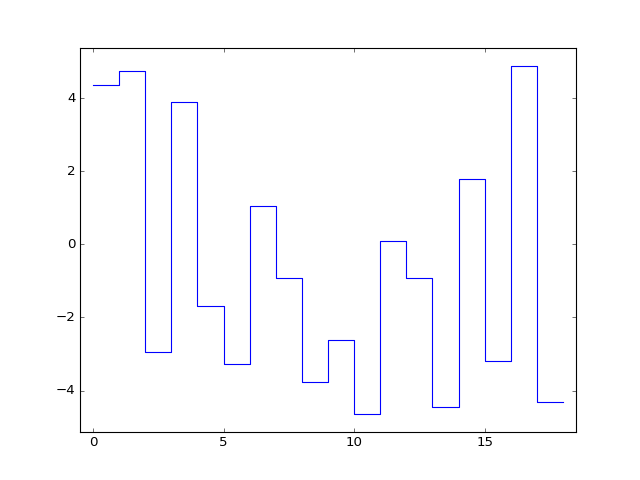

<IPython.core.display.Javascript object>


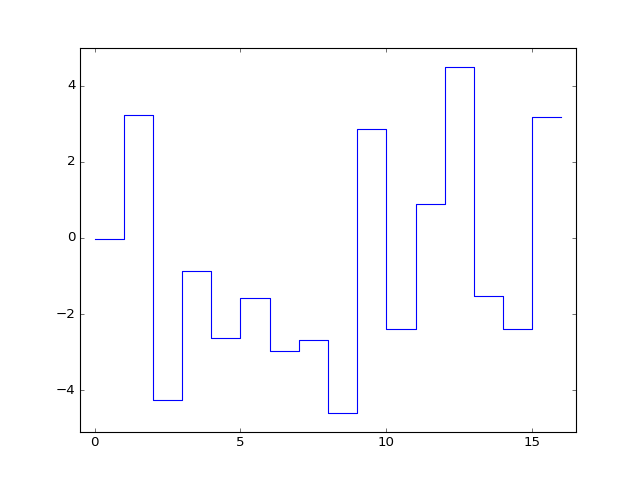

<IPython.core.display.Javascript object>


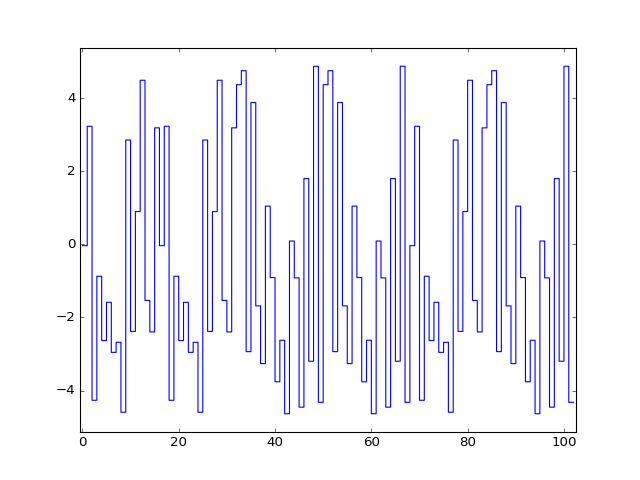

In [4]:
import random

random.seed('Some seed such that numbers generated are predictable')
parameters = {parameter_name: random.random() * 10 - 5 for parameter_name in all_epsilons}

%matplotlib notebook
from qctoolkit.pulses import plot
plot(gates[0], parameters)
plot(gates[1], parameters)
plot(sequences[1], parameters)

We now must construct the $S_k'$. For simplicity, we assume that there is only one initialization and one measurement pulse which are defined somehow and define only stubs here. We also define a waiting pulse with a variable length:

In [5]:
# stub for an initialization pulse of length 4
init = TablePulseTemplate()
init.add_entry(0, 5)
init.add_entry(4, 0, 'linear')

# stub for a measurement pulse of length 12
measure = TablePulseTemplate()
measure.add_entry(0, 0)
measure.add_entry(12, 5, 'linear')

# a wating pulse
wait = TablePulseTemplate()
wait.add_entry('wait_duration', 0)

For our example, let us assume that we want all $S_k'$ to take 200 ns (since we've chosen the $S_k$ to be rather short). We know that the duration of our gate pulses in nanoseconds is equal to the number of entries in the `TablePulseTemplate` objects (each voltage level is held for one unit of time in the tables which corresponds to $\Delta t = 1$ ns). Accordingly, the init pulse lasts for 4 ns and the measure pulse for 12 ns. The required length of the wait pulse can then be computed as follows:

In [6]:
wait_times = []
desired_time = 200

for m_k in m:
    duration_k = 4 + 12 # init + measurement duration
    for g_ki in m_k:
        duration_k += len(gates[g_ki].entries) # add the number of entries of all gates in the sequence
    wait_time_k = desired_time - duration_k
    wait_times.append(wait_time_k)
    
print(wait_times)

[21, 76, 40]


Finally we can construct the $S_k'$:

In [7]:
# an identity mapping for all epsilons
all_epsilons_map = {param_name: param_name for param_name in all_epsilons}

final_sequences = []
for k in range(0, len(sequences)):
    
    #prepare the subtemplate of the sequence S_k'
    subtemplates = []
    
    # include the wait pulse first. pass in the appropriate wait time.
    # note that the wait time has to be cast to a string. In parameter mappings, some string containing a mathematical
    # expression is expected. Here, we provide a mathematical expression consisting only of a constant value.
    subtemplates.append((wait, {'wait_duration': str(wait_times[k])}))
    
    # append the init pulse
    subtemplates.append((init, {}))
    
    # append the k-th sequence
    subtemplates.append((sequences[k], all_epsilons_map))
    
    # append the measuring
    subtemplates.append((measure, {}))
    
    # construct the object for S_k'
    s_k_prime = SequencePulseTemplate(subtemplates, all_epsilons)
    final_sequences.append(s_k_prime)

Let us plot $S_1'$ to see what whether we've accomplished our goal:

<IPython.core.display.Javascript object>


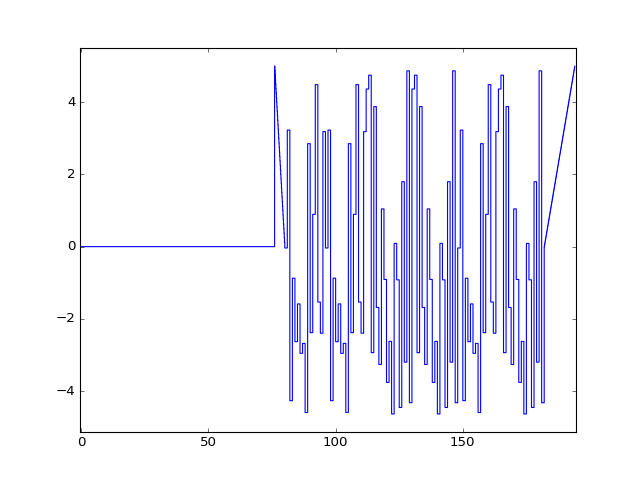

In [8]:
plot(final_sequences[1], parameters)

Finally, we construct a single scanline which just repeats all three sequences over and over again. Since our $S_k'$ are short, we just build a scanline with a duration of 0.6 microseconds. With a duration for each $S_k'$ of 200 ns, we can fit 1'000 repetitions of $S_1' | S_2' | S_3'$ in our scanline. 

In [9]:
from qctoolkit.pulses import Sequencer

subtemplates = []
for i in range(0, 1000):
    subtemplates.append((final_sequences[0], all_epsilons_map))
    subtemplates.append((final_sequences[1], all_epsilons_map))
    subtemplates.append((final_sequences[2], all_epsilons_map))
    
scanline = SequencePulseTemplate(subtemplates, all_epsilons)